In [1]:
import numpy as np
import torch 
from model import PINNS_MLP_kovasznay
from loss_ball import *
from visualization import *
import matplotlib.pyplot as plt
import seaborn as sns
from ball_problem import *

In [2]:
#reynolds and viscosity
Re = 40 
nu = 1/Re 
lambda_ = -Re/2 + np.sqrt((Re/2)**2 + 4 *np.pi**2)

In [3]:
def array_balancing(liste1, liste2) : 
    len1 = len(liste1)
    len2 = len(liste2)

    # Ajouter des zéros pour égaliser les tailles
    if len1 < len2:
        liste1 = np.pad(liste1, (0, len2 - len1), mode='constant', constant_values=0)
    elif len2 < len1:
        liste2 = np.pad(liste2, (0, len1 - len2), mode='constant', constant_values=0)


In [6]:


eps = 1e-5

def train_ajustment(X_flat, X_left, X_right, X_bot, X_top, X_ball, cond_left, cond_right, cond_bot, cond_top, cond_ball, beta, N_EPOCH, lr=1e-3, alpha=1, verbose=False, plot=False, nu=1/40):
    model = PINNS_MLP_kovasznay()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses_equa = np.zeros(N_EPOCH)
    losses_boundary = np.zeros(N_EPOCH)
    for i in range(N_EPOCH):
            
        optimizer.zero_grad()
        loss_equa = model_loss_equation_ball(model, X_flat, nu)
        loss_boundary = model_loss_boundary_ball(model, X_left, X_right, X_bot, X_top, X_ball, cond_left, cond_right, cond_bot, cond_top, cond_ball)


        loss_boundary_grads = torch.autograd.grad(loss_boundary, model.parameters(), create_graph=True, allow_unused=True)
        loss_equa_grads = torch.autograd.grad(loss_equa, model.parameters(), create_graph=True, allow_unused=True)

        total_grad_loss_boundary, total_grad_loss_equa = np.empty(0), np.empty(0)

        for grad in loss_boundary_grads : 
            if grad is not None : 
                total_grad_loss_boundary = np.append(total_grad_loss_boundary, np.abs(grad.detach().numpy()))
        
        for grad in loss_equa_grads : 
            if grad is not None : 
                total_grad_loss_equa = np.append(total_grad_loss_equa, np.abs(grad.detach().numpy()))    

        array_balancing(total_grad_loss_equa, total_grad_loss_boundary)

        norm_grad_equa = np.linalg.norm(total_grad_loss_equa)
        norm_grad_boundary = np.linalg.norm(total_grad_loss_boundary)

        max_grad_equa = np.max(total_grad_loss_equa)
        mean_grad_equa = np.mean(total_grad_loss_equa)
        max_grad_boundary = np.max(total_grad_loss_boundary)
        mean_grad_boundary = np.mean(total_grad_loss_boundary)

        n_beta = mean_grad_equa/(mean_grad_boundary+eps)

        if i == 0 : 
            beta = n_beta
        else : 
            beta = np.min([0.1 * n_beta + (1-0.1) * beta, 1e2])

        loss = alpha*loss_equa + beta*loss_boundary
        
        if (i+1) % 10 == 0 and verbose:
            print(f'ite {i+1}, loss equa: {loss_equa}, loss boundary: {loss_boundary}, beta opti: {beta}')

        loss.backward()
        optimizer.step()

        losses_equa[i] = loss_equa.item()
        losses_boundary[i] = loss_boundary.item()

    if plot:
        plt.plot(range(N_EPOCH), losses_equa, label='Equation loss')
        plt.plot(range(N_EPOCH), losses_boundary, label='Boundary condition loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title(r'Loss vs epoch, $(\alpha, \beta) = $' + f'({alpha}, {int(beta)})')
        plt.legend(loc='upper right')
        plt.show()

    return losses_equa, losses_boundary, model

ite 10, loss equa: 0.011219208128750324, loss boundary: 0.12755274772644043, beta opti: 0.10231548226681367
ite 20, loss equa: 0.0050725871697068214, loss boundary: 0.06665676087141037, beta opti: 0.1252844750681954
ite 30, loss equa: 0.0023624596651643515, loss boundary: 0.032960355281829834, beta opti: 0.16221094806793473
ite 40, loss equa: 0.0024802128318697214, loss boundary: 0.023637952283024788, beta opti: 0.21403764499111785
ite 50, loss equa: 0.0015903516905382276, loss boundary: 0.02156461775302887, beta opti: 0.21395566088813656
ite 60, loss equa: 0.0011360590578988194, loss boundary: 0.02049611136317253, beta opti: 0.224078817713555
ite 70, loss equa: 0.0010383707704022527, loss boundary: 0.018877286463975906, beta opti: 0.2148465401473187
ite 80, loss equa: 0.0008731575217097998, loss boundary: 0.01804204285144806, beta opti: 0.19730517284128876
ite 90, loss equa: 0.0007187207811512053, loss boundary: 0.017417646944522858, beta opti: 0.1798244691929711
ite 100, loss equa: 0

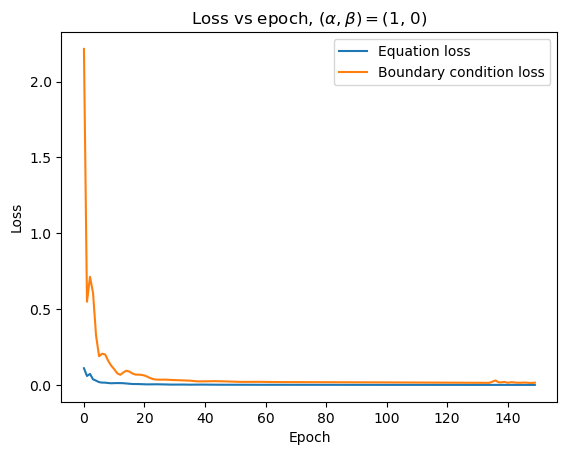

In [7]:

beta_star = 1e4

X_left, X_right, X_top, X_bottom, X_ball, UV_left, DUDX_DVDX_right, UV_top, UV_bottom, UV_BALL = boundary_conditions_ball_problem(100, 100)
X_flat = get_domain(X_left, X_right, X_top, X_bottom, X_ball) #to complete


_, _, model_star = train_ajustment(X_flat, X_left, X_right, X_bottom, X_top, X_ball, UV_left, DUDX_DVDX_right, UV_bottom, UV_top, UV_BALL, beta_star, 150, verbose=True, plot=True) #to complete

Y_hat = model_star(X_flat)

U_hat = Y_hat[:,0]
V_hat = Y_hat[:,1]
P_hat = Y_hat[:,2]

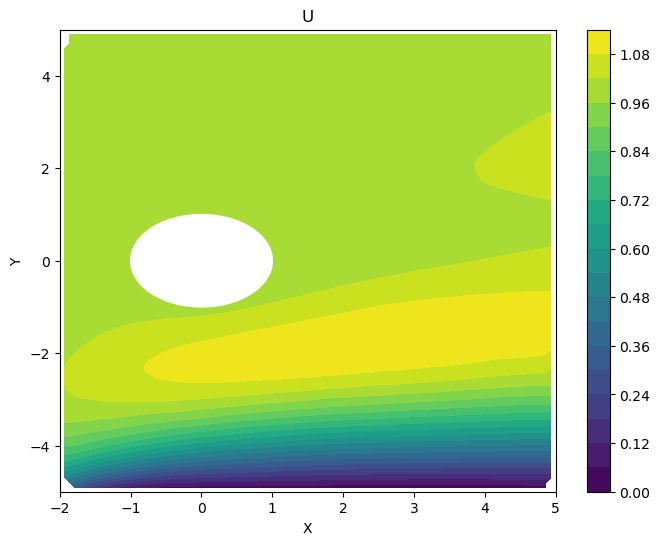

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Données des points en 2D avec des valeurs assignées
# Exemple de points et de leurs valeurs associées
points = X_flat.detach().numpy()  # Coordonnées des points
values = U_hat.detach().numpy() # Valeurs assignées à ces points

# Domaine pour la carte de contours
x_min, x_max = -2, 5
y_min, y_max = -5, 5

# Création d'une grille de points dans le domaine
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# Interpolation des valeurs sur la grille
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Création de la carte de contours
plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, 20, cmap='viridis')

# Ajout du cercle blanc rempli
circle = plt.Circle((0, 0), 1, color='white', fill=True)  # fill=True pour remplir le cercle
plt.gca().add_artist(circle)

# Configuration de l'affichage
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar(contour)

# Titre et étiquettes des axes
plt.title('U')
plt.xlabel('X')
plt.ylabel('Y')

# Affichage
plt.show()


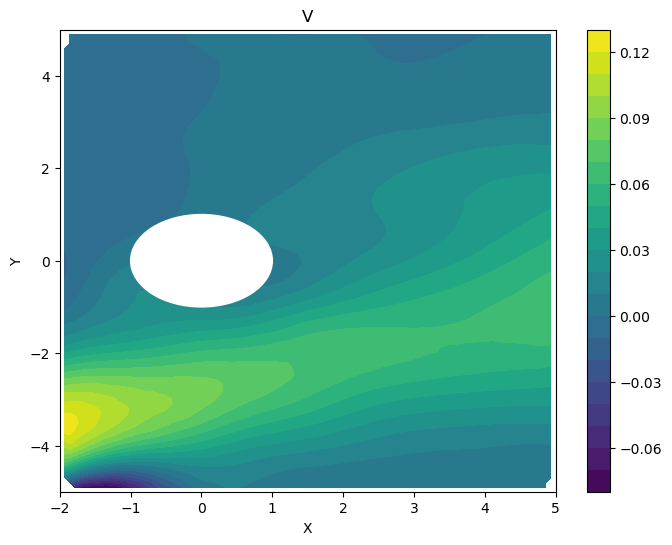

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Données des points en 2D avec des valeurs assignées
# Exemple de points et de leurs valeurs associées
points = X_flat.detach().numpy()  # Coordonnées des points
values = V_hat.detach().numpy() # Valeurs assignées à ces points

# Domaine pour la carte de contours
x_min, x_max = -2, 5
y_min, y_max = -5, 5

# Création d'une grille de points dans le domaine
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# Interpolation des valeurs sur la grille
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Création de la carte de contours
plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, 20, cmap='viridis')

# Ajout du cercle blanc rempli
circle = plt.Circle((0, 0), 1, color='white', fill=True)  # fill=True pour remplir le cercle
plt.gca().add_artist(circle)

# Configuration de l'affichage
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar(contour)

# Titre et étiquettes des axes
plt.title('V')
plt.xlabel('X')
plt.ylabel('Y')

# Affichage
plt.show()


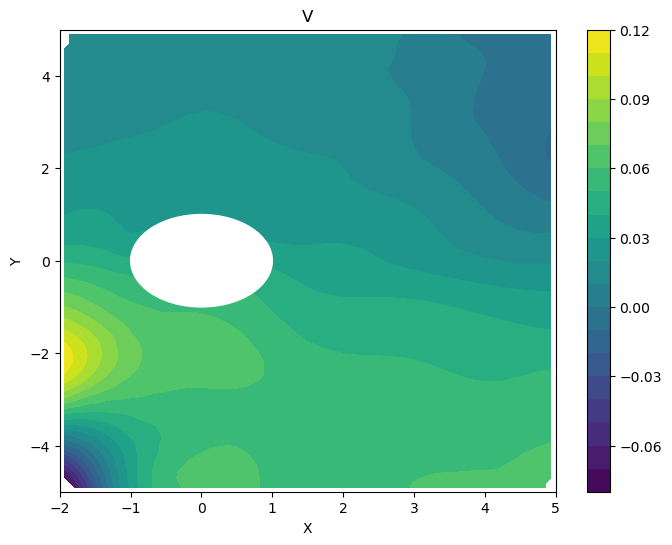

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

# Données des points en 2D avec des valeurs assignées
# Exemple de points et de leurs valeurs associées
points = X_flat.detach().numpy()  # Coordonnées des points
values = P_hat.detach().numpy() # Valeurs assignées à ces points

# Domaine pour la carte de contours
x_min, x_max = -2, 5
y_min, y_max = -5, 5

# Création d'une grille de points dans le domaine
grid_x, grid_y = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]

# Interpolation des valeurs sur la grille
grid_z = griddata(points, values, (grid_x, grid_y), method='linear')

# Création de la carte de contours
plt.figure(figsize=(8, 6))
contour = plt.contourf(grid_x, grid_y, grid_z, 20, cmap='viridis')

# Ajout du cercle blanc rempli
circle = plt.Circle((0, 0), 1, color='white', fill=True)  # fill=True pour remplir le cercle
plt.gca().add_artist(circle)

# Configuration de l'affichage
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.colorbar(contour)

# Titre et étiquettes des axes
plt.title('V')
plt.xlabel('X')
plt.ylabel('Y')

# Affichage
plt.show()
